In [18]:
!pip install lpips
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, Subset
import torchvision
from torchvision import transforms
import numpy as np
import cv2
import os
import glob
import time
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
import lpips
from sklearn.model_selection import train_test_split

# Initialize LPIPS metric
loss_fn_vgg = lpips.LPIPS(net='vgg').cuda()

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /usr/local/lib/python3.12/dist-packages/lpips/weights/v0.1/vgg.pth


In [ ]:
import torch
import torch.nn as nn



class ChannelAttention(nn.Module):
    def __init__(self, channel, reduction=8):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channel, channel // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channel // reduction, channel, bias=False),
            nn.Sigmoid()
        )
    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)

class PixelAttention(nn.Module):
    def __init__(self, channel):
        super(PixelAttention, self).__init__()
        self.pa = nn.Sequential(
            nn.Conv2d(channel, channel // 8, 1, padding=0, bias=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(channel // 8, 1, 1, padding=0, bias=True),
            nn.Sigmoid()
        )
    def forward(self, x):
        y = self.pa(x)
        return x * y

class FABlock(nn.Module):
    """ Feature Attention Block: Combines Channel and Pixel Attention """
    def __init__(self, channel):
        super(FABlock, self).__init__()
        self.conv1 = nn.Conv2d(channel, channel, 3, padding=1, bias=True)
        self.relu = nn.LeakyReLU(0.2, inplace=True)
        self.conv2 = nn.Conv2d(channel, channel, 3, padding=1, bias=True)
        self.ca = ChannelAttention(channel)
        self.pa = PixelAttention(channel)

    def forward(self, x):
        res = self.relu(self.conv1(x))
        res = self.conv2(res)
        res = self.ca(res)
        res = self.pa(res)
        return x + res



class DehazeNet_IHAZE(nn.Module):
    def __init__(self, blocks=6, conv_dim=64):
        super(DehazeNet_IHAZE, self).__init__()
        self.pre_conv = nn.Conv2d(3, conv_dim, 3, padding=1, bias=True)

        
        self.feature_extraction = nn.ModuleList([
            FABlock(conv_dim) for _ in range(blocks)
        ])

        
        self.fusion = nn.Conv2d(conv_dim * (blocks//2), conv_dim, 1, padding=0, bias=True)

        self.post_conv = nn.Sequential(
            nn.Conv2d(conv_dim, conv_dim, 3, padding=1, bias=True),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(conv_dim, 3, 3, padding=1, bias=True)
        )

    def forward(self, x):
        
        x_feat = self.pre_conv(x)

        # Collect intermediate features for fusion
        outputs = []
        res = x_feat
        for i, block in enumerate(self.feature_extraction):
            res = block(res)
            if i % 2 == 1: # Collect every 2nd block feature
                outputs.append(res)

        # Multi-level Feature Fusion
        fused = self.fusion(torch.cat(outputs, dim=1))

        # Reconstruction via Residual Learning
        # The model predicts the 'haze' and subtracts/adds to input
        out = self.post_conv(fused + x_feat)
        return torch.clamp(x + out, 0, 1) # Global Residual Connection

# Initialize for I-HAZE
model = DehazeNet_IHAZE().to(device)

In [20]:
class IHazeDataset(Dataset):
    def __init__(self, gt_path, hazy_path, size=512):
        self.gt_images = sorted(glob.glob(os.path.join(gt_path, "*.jpg")) + glob.glob(os.path.join(gt_path, "*.png")))
        self.hazy_images = sorted(glob.glob(os.path.join(hazy_path, "*.jpg")) + glob.glob(os.path.join(hazy_path, "*.png")))
        self.size = size

    def __getitem__(self, index):
        gt = cv2.cvtColor(cv2.imread(self.gt_images[index]), cv2.COLOR_BGR2RGB)
        hazy = cv2.cvtColor(cv2.imread(self.hazy_images[index]), cv2.COLOR_BGR2RGB)
        gt = cv2.resize(gt, (self.size, self.size)) / 255.0
        hazy = cv2.resize(hazy, (self.size, self.size)) / 255.0
        return torch.from_numpy(gt).float().permute(2,0,1), torch.from_numpy(hazy).float().permute(2,0,1)

    def __len__(self):
        return len(self.gt_images)

# CONFIG PATHS
GT_PATH = "/content/dataset/I HAZY NTIRE 2018/GT"
HAZY_PATH = "/content/dataset/I HAZY NTIRE 2018/hazy"

full_dataset = IHazeDataset(GT_PATH, HAZY_PATH)
train_idx, temp_idx = train_test_split(np.arange(len(full_dataset)), test_size=0.3, random_state=42)
val_idx, test_idx = train_test_split(temp_idx, test_size=0.5, random_state=42)

train_loader = DataLoader(Subset(full_dataset, train_idx), batch_size=4, shuffle=True)
val_loader = DataLoader(Subset(full_dataset, val_idx), batch_size=1)
test_loader = DataLoader(Subset(full_dataset, test_idx), batch_size=1)

print(f"Train: {len(train_idx)}, Val: {len(val_idx)}, Test: {len(test_idx)}")

Train: 21, Val: 4, Test: 5


In [21]:
def compute_metrics(gt, pred):
    # gt, pred are (C, H, W) tensors in [0, 1]
    gt_np = gt.permute(1, 2, 0).cpu().numpy()
    pred_np = pred.permute(1, 2, 0).cpu().numpy()

    mse = np.mean((gt_np - pred_np) ** 2)
    psnr = peak_signal_noise_ratio(gt_np, pred_np, data_range=1.0)
    ssim = structural_similarity(gt_np, pred_np, data_range=1.0, channel_axis=-1)

    # LPIPS requires [-1, 1] range
    lpips_val = loss_fn_vgg(gt.unsqueeze(0).cuda() * 2 - 1, pred.unsqueeze(0).cuda() * 2 - 1).item()

    return mse, psnr, ssim, lpips_val

def visualize_results(model, loader, title, num_samples=10):
    model.eval()
    samples_shown = 0
    plt.figure(figsize=(20, 6))

    with torch.no_grad():
        for gt, hazy in loader:
            if samples_shown >= num_samples: break
            pred = model(hazy.cuda()).clamp(0, 1).cpu()

            # Plot Hazy
            plt.subplot(3, num_samples, samples_shown + 1)
            plt.imshow(hazy[0].permute(1,2,0))
            if samples_shown == 0: plt.ylabel("Hazy Input", fontsize=12)
            plt.axis('off')

            # Plot Pred
            plt.subplot(3, num_samples, num_samples + samples_shown + 1)
            plt.imshow(pred[0].permute(1,2,0))
            if samples_shown == 0: plt.ylabel("Prediction", fontsize=12)
            plt.axis('off')

            # Plot GT
            plt.subplot(3, num_samples, 2*num_samples + samples_shown + 1)
            plt.imshow(gt[0].permute(1,2,0))
            if samples_shown == 0: plt.ylabel("Ground Truth", fontsize=12)
            plt.axis('off')

            samples_shown += 1
    plt.suptitle(f"Results for {title} Set", fontsize=16)
    plt.tight_layout()
    plt.show()

Starting Training...
Epoch 1 Loss: 0.1913
Epoch 2 Loss: 0.2059
Epoch 3 Loss: 0.2313
Epoch 4 Loss: 0.1437
Epoch 5 Loss: 0.1193
Epoch 6 Loss: 0.1598
Epoch 7 Loss: 0.0804
Epoch 8 Loss: 0.1981
Epoch 9 Loss: 0.1119
Epoch 10 Loss: 0.1647

--- Training Metrics ---
MSE: 0.020260 | PSNR: 17.1729 | SSIM: 0.5099 | LPIPS: 0.5085


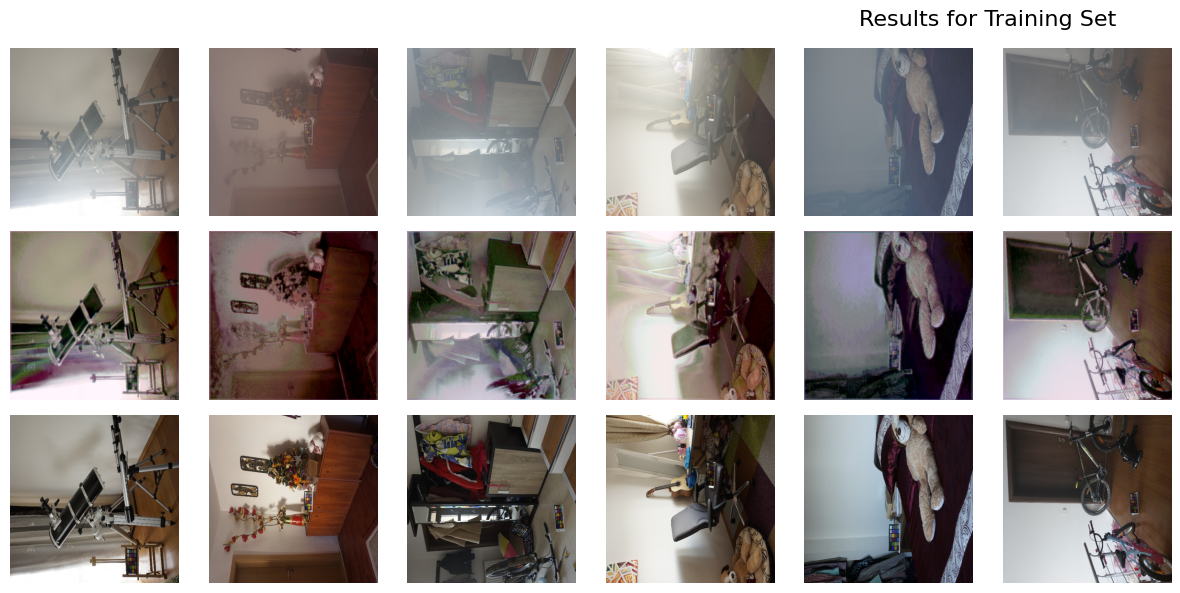


--- Validation Metrics ---
MSE: 0.032309 | PSNR: 15.4153 | SSIM: 0.5113 | LPIPS: 0.5114


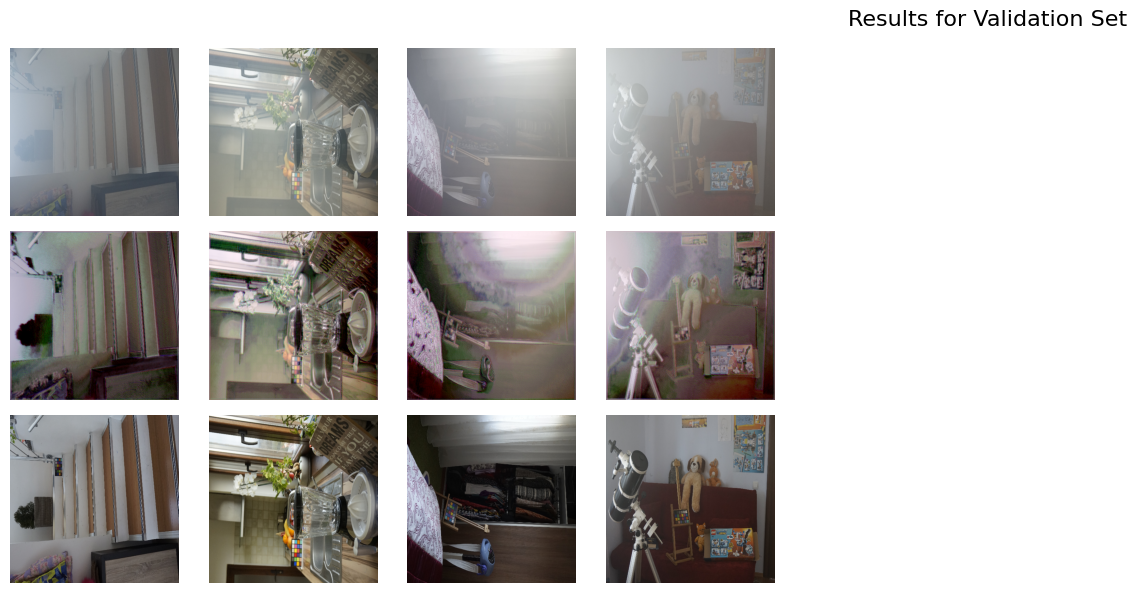


--- Testing Metrics ---
MSE: 0.017046 | PSNR: 18.0156 | SSIM: 0.5328 | LPIPS: 0.4870


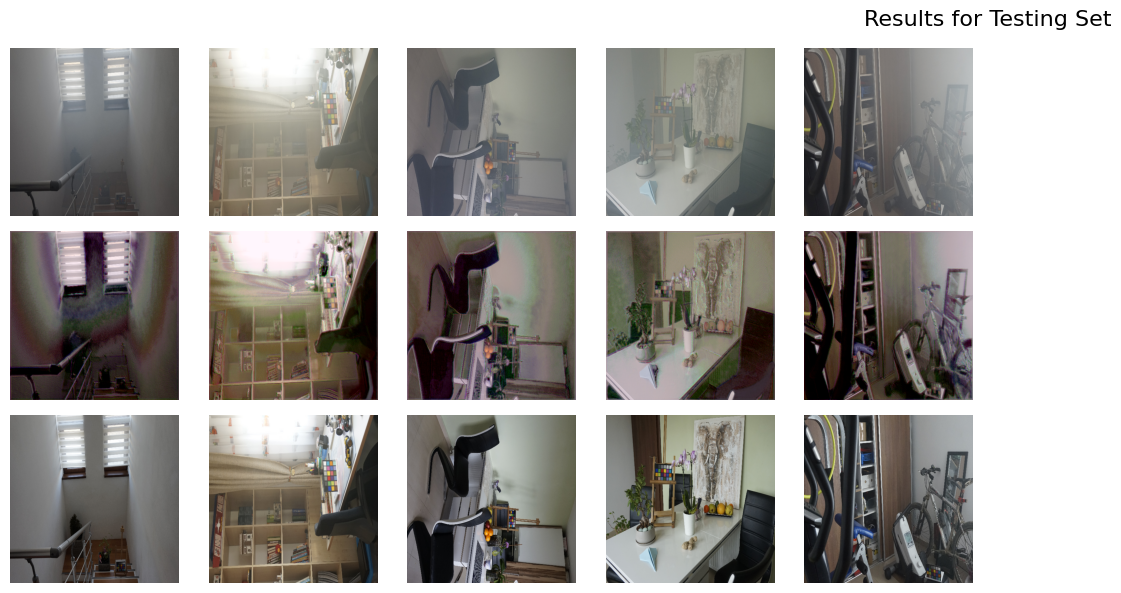

In [ ]:
device = torch.device("cuda")
model = DehazeNet().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.L1Loss()


print("Starting Training...")
model.train()
for epoch in range(10): 
    for gt, hazy in train_loader:
        optimizer.zero_grad()
        out = model(hazy.to(device))
        loss = criterion(out, gt.to(device))
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1} Loss: {loss.item():.4f}")


def evaluate_set(loader, name):
    avg_metrics = np.zeros(4)
    model.eval()
    with torch.no_grad():
        for gt, hazy in loader:
            pred = model(hazy.cuda()).clamp(0, 1)[0]
            m = compute_metrics(gt[0], pred.cpu())
            avg_metrics += np.array(m)
    avg_metrics /= len(loader)
    print(f"\n--- {name} Metrics ---")
    print(f"MSE: {avg_metrics[0]:.6f} | PSNR: {avg_metrics[1]:.4f} | SSIM: {avg_metrics[2]:.4f} | LPIPS: {avg_metrics[3]:.4f}")


evaluate_set(train_loader, "Training")
visualize_results(model, train_loader, "Training")

evaluate_set(val_loader, "Validation")
visualize_results(model, val_loader, "Validation")

evaluate_set(test_loader, "Testing")
visualize_results(model, test_loader, "Testing")